# Convolutional VAE
**By François Chollet (and contributors), author of the Building AE with Keras tutorial**:https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
'''This script demonstrates how to build a variational autoencoder
with Keras and deconvolution layers.
# Reference
- Auto-Encoding Variational Bayes
  https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

/home/bastien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
K.image_data_format()

'channels_last'

In [ ]:
import pyriemann.utils.covariance as cov
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).
    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

### Much Better results: 64 filters (instead of 32) and training on all the data set for 5 epochs only

/home/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Output "conv2d_10" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_10" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 1)    5           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   320         conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

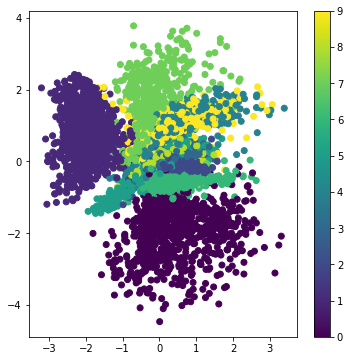

In [14]:
'''This script demonstrates how to build a variational autoencoder
with Keras and deconvolution layers.
# Reference
- Auto-Encoding Variational Bayes
  https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 5

x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')
vae.summary()

# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

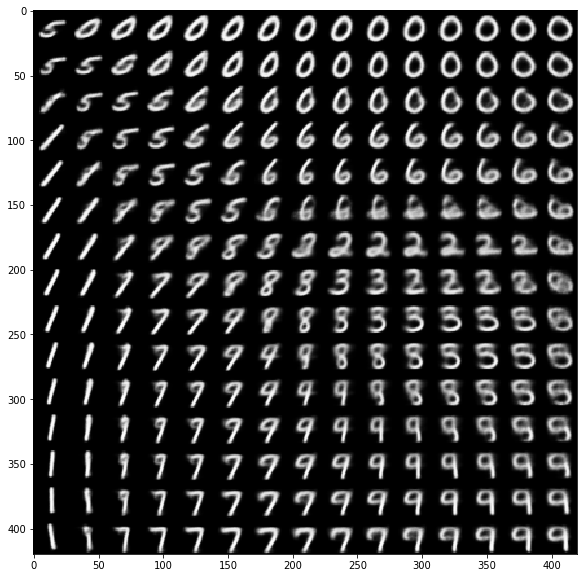

In [15]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

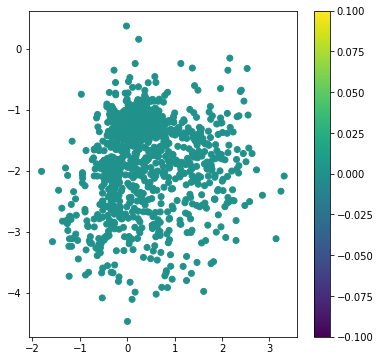

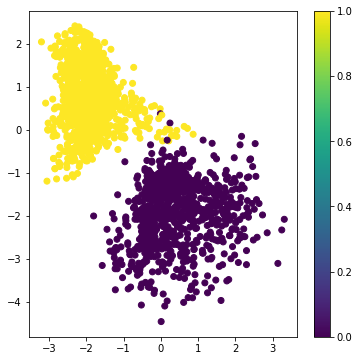

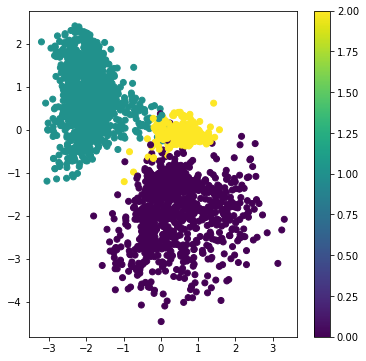

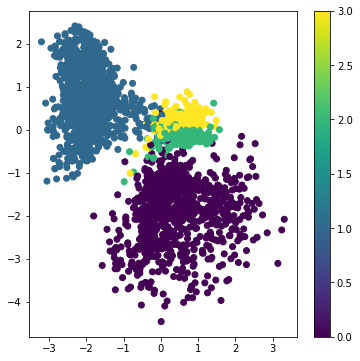

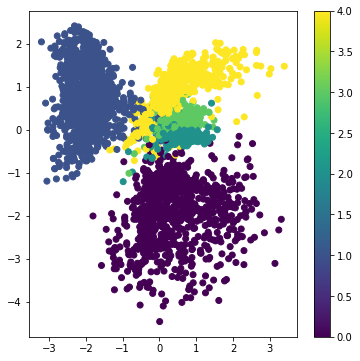

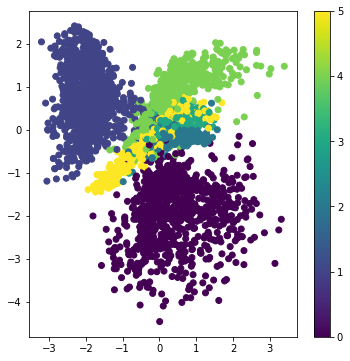

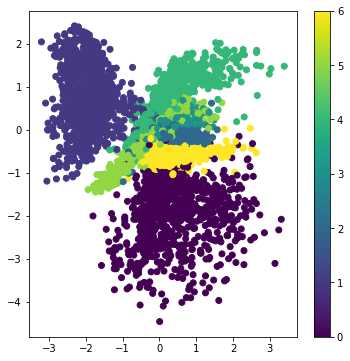

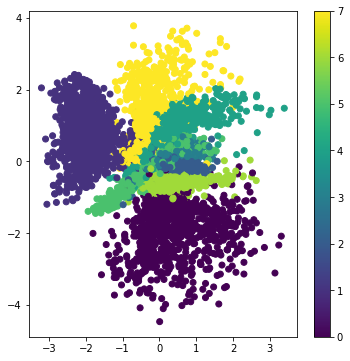

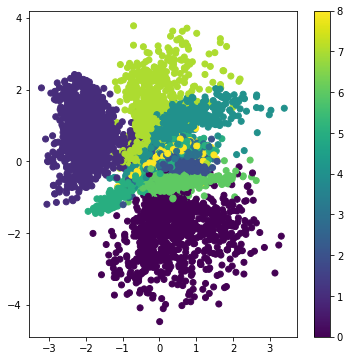

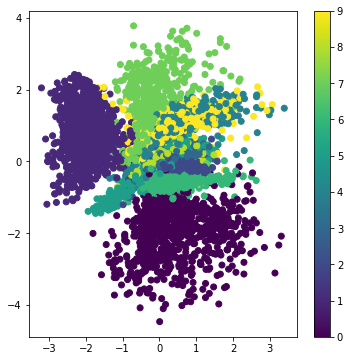

In [73]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for i in range(10):
    temp=y_test<=i
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[temp, 0], x_test_encoded[temp, 1], c=y_test[temp])
    plt.colorbar()
    plt.show()

In [75]:
import pyriemann.utils.covariance as cov
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).
    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

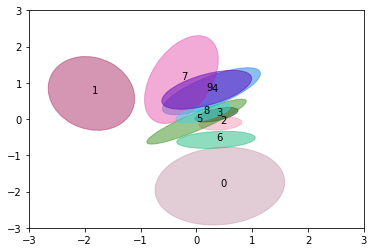

In [76]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for i in range(10):
    temp=y_test==i
    A1=cov.empirical_covariance(x_test_encoded[temp, :])
    M1=np.mean(x_test_encoded[temp, :],axis=0)
    #plt.figure(figsize=(6, 6))
    plot_cov_ellipse(A1/2, M1,alpha=0.5, color=np.random.random(3))
    plt.text(M1[0],M1[1],str(i))
    #plt.scatter(x_test_encoded[temp, 0], x_test_encoded[temp, 1], c=y_test[temp])
    #plt.colorbar()
plt.xlim([-3,3])
plt.ylim([-3,3])   
plt.show()

### Visualizing the basis images

In [77]:
H = encoder.predict(x_test, batch_size=batch_size)

In [78]:
H.shape

(10000, 2)

In [82]:
W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], digit_size*digit_size)))

In [83]:
W.shape

(2, 784)

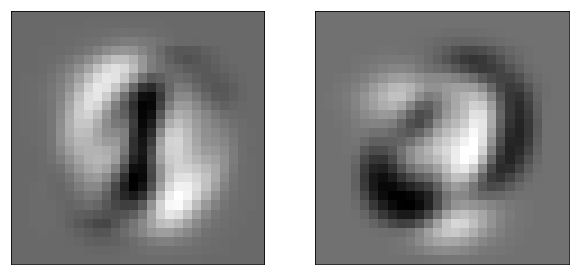

In [90]:
#visualizing the basis images
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(W[0].reshape((digit_size, digit_size)), cmap='gray')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(W[1].reshape((digit_size, digit_size)), cmap='gray')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()

### Trying to train on only 10000 images (instead of 60000)

In [91]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64 
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 25

In [92]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 1)    5           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 64)   320         conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

/home/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: Output "conv2d_15" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_15" during training.


In [93]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train.shape:', x_train.shape)
x_train=x_train[0:10000,:,:]

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
print('x_train.shape:', x_train.shape)

x_train.shape: (60000, 28, 28)
x_train.shape: (10000, 28, 28, 1)


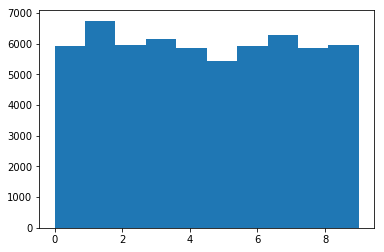

In [95]:
# Let us assure that all digits are represented in the subset used for training
plt.hist(y_train)
plt.show()

In [96]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 10000 samples, validate on 10000 samples
Epoch 1/25
10000/10000 [==============================] - 126s 13ms/step - loss: 227.7749 - val_loss: 208.5916
Epoch 2/25
10000/10000 [==============================] - 153s 15ms/step - loss: 205.4137 - val_loss: 201.4569
Epoch 3/25
10000/10000 [==============================] - 142s 14ms/step - loss: 189.7271 - val_loss: 189.3133
Epoch 4/25
10000/10000 [==============================] - 145s 15ms/step - loss: 183.1736 - val_loss: 180.1059
Epoch 5/25
10000/10000 [==============================] - 150s 15ms/step - loss: 176.5510 - val_loss: 174.6068
Epoch 6/25
10000/10000 [==============================] - 127s 13ms/step - loss: 170.7966 - val_loss: 167.2734
Epoch 7/25
10000/10000 [==============================] - 155s 15ms/step - loss: 166.1738 - val_loss: 163.4071
Epoch 8/25
10000/10000 [==============================] - 138s 14ms/step - loss: 162.3527 - val_loss: 160.3946
Epoch 9/25
10000/10000 [==============================] - 117s

In [97]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

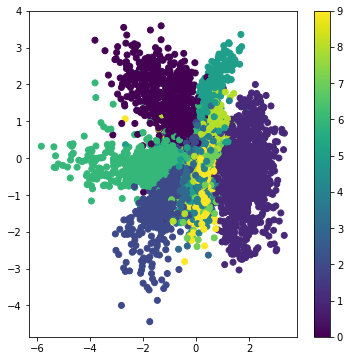

In [98]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [99]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

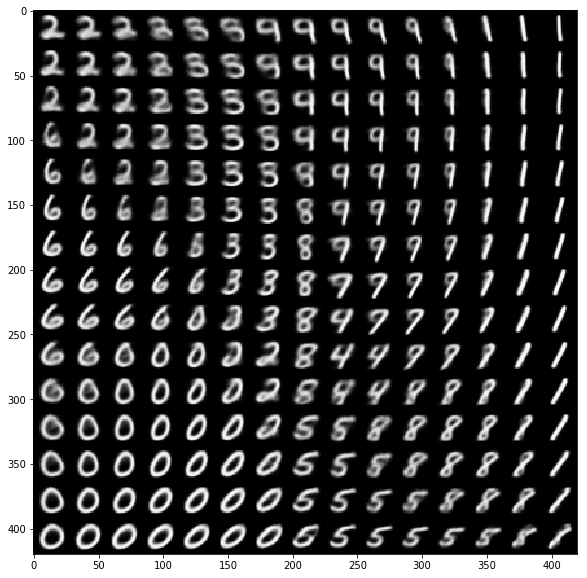

In [100]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

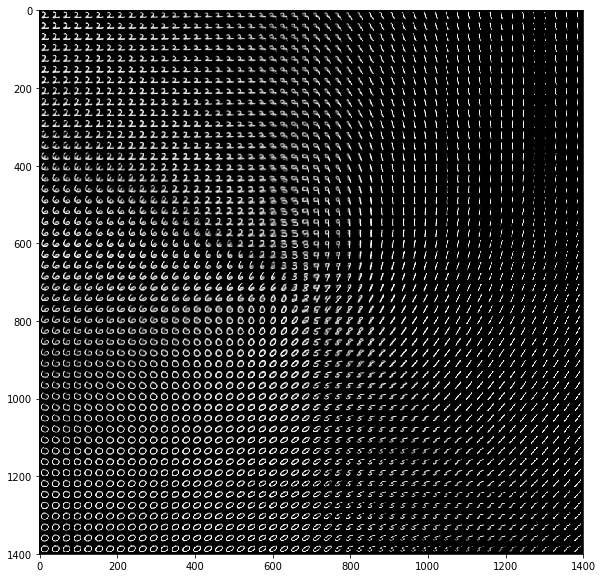

In [101]:
# display a 2D manifold of the digits
n = 50  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

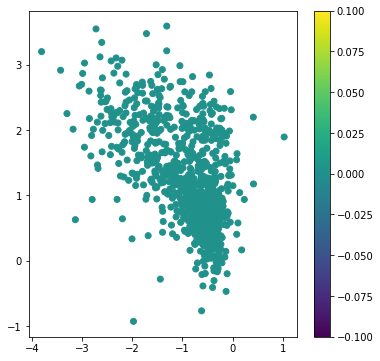

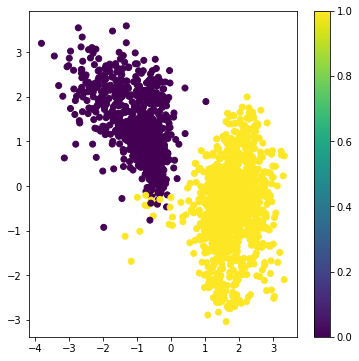

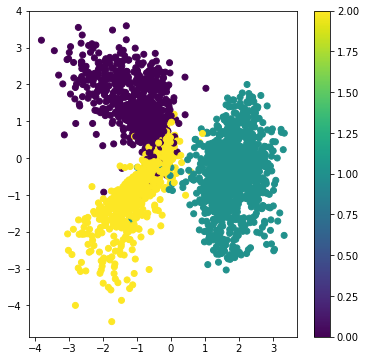

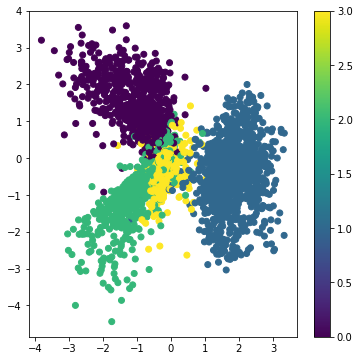

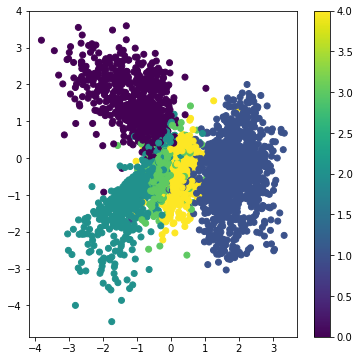

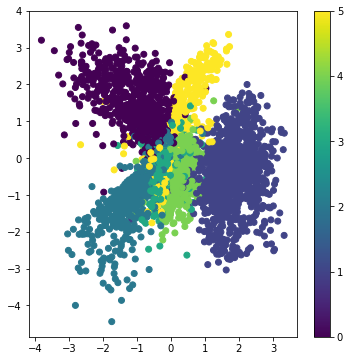

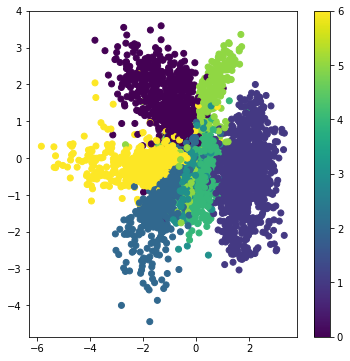

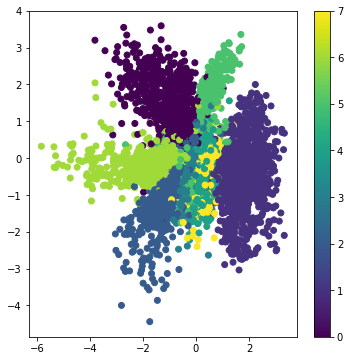

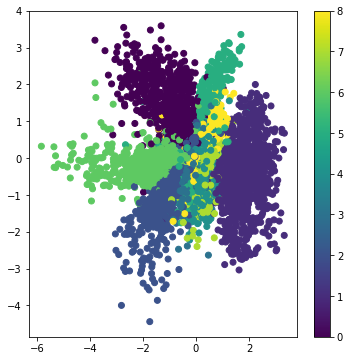

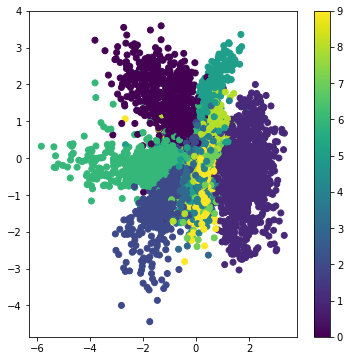

In [102]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for i in range(10):
    temp=y_test<=i
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[temp, 0], x_test_encoded[temp, 1], c=y_test[temp])
    plt.colorbar()
    plt.show()

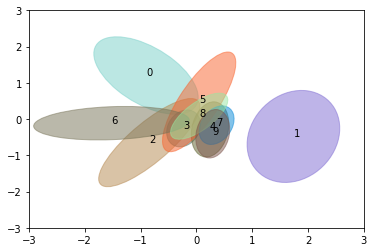

In [103]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for i in range(10):
    temp=y_test==i
    A1=cov.empirical_covariance(x_test_encoded[temp, :])
    M1=np.mean(x_test_encoded[temp, :],axis=0)
    #plt.figure(figsize=(6, 6))
    plot_cov_ellipse(A1/2, M1,alpha=0.5, color=np.random.random(3))
    plt.text(M1[0],M1[1],str(i))
    #plt.scatter(x_test_encoded[temp, 0], x_test_encoded[temp, 1], c=y_test[temp])
    #plt.colorbar()
plt.xlim([-3,3])
plt.ylim([-3,3])   
plt.show()

### Architecture with only 32 filters (instead of 64) but training on 60000 data points

In [104]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 32 
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 10

In [105]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 1)    5           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 14, 14, 32)   160         conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 14, 14, 32)   9248        conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 

/home/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: Output "conv2d_20" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_20" during training.


In [106]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train.shape:', x_train.shape)

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
print('x_train.shape:', x_train.shape)

x_train.shape: (60000, 28, 28)
x_train.shape: (60000, 28, 28, 1)


In [107]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 237s 4ms/step - loss: 182.9681 - val_loss: 164.1842
Epoch 2/10
60000/60000 [==============================] - 250s 4ms/step - loss: 156.1287 - val_loss: 153.3341
Epoch 3/10
60000/60000 [==============================] - 255s 4ms/step - loss: 150.8361 - val_loss: 148.6417
Epoch 4/10
60000/60000 [==============================] - 238s 4ms/step - loss: 147.9305 - val_loss: 146.6624
Epoch 5/10
60000/60000 [==============================] - 229s 4ms/step - loss: 145.9312 - val_loss: 146.1327
Epoch 6/10
60000/60000 [==============================] - 219s 4ms/step - loss: 144.5271 - val_loss: 144.8194
Epoch 7/10
60000/60000 [==============================] - 236s 4ms/step - loss: 143.4955 - val_loss: 143.9413
Epoch 8/10
60000/60000 [==============================] - 246s 4ms/step - loss: 142.6123 - val_loss: 143.3529
Epoch 9/10
60000/60000 [==============================] - 253s 4ms/ste

In [108]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

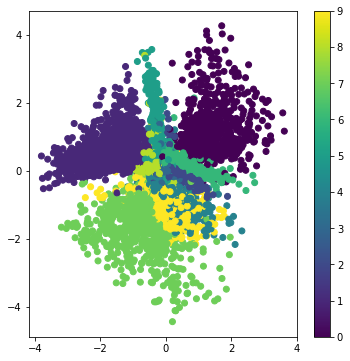

In [109]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [110]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

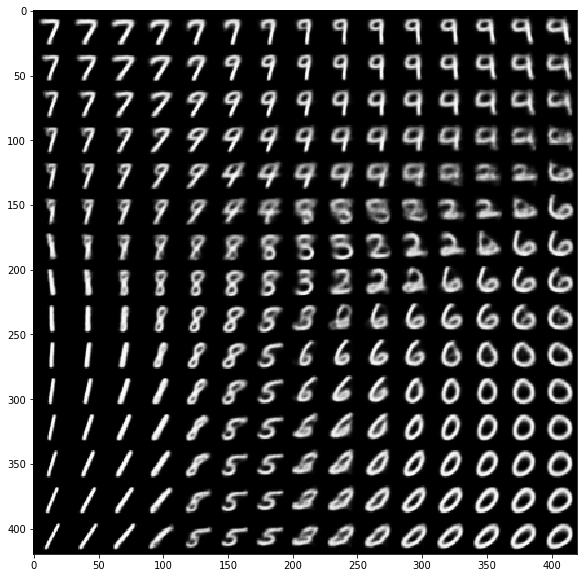

In [111]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

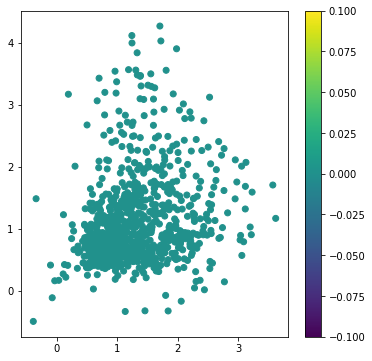

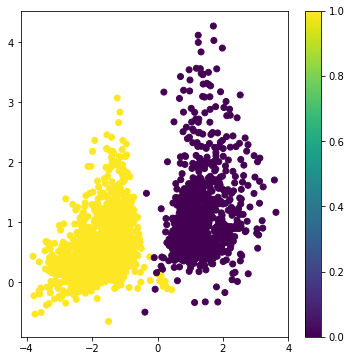

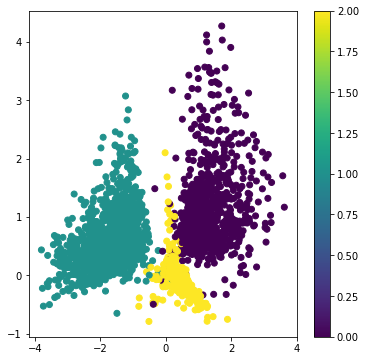

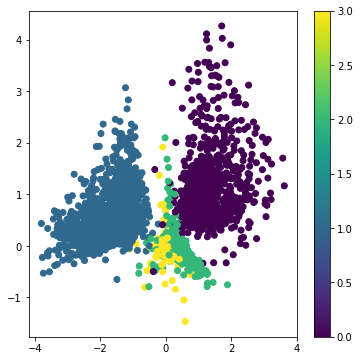

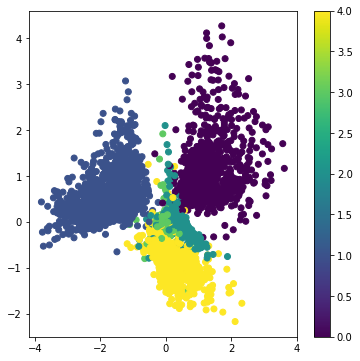

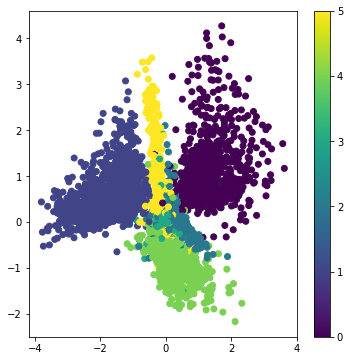

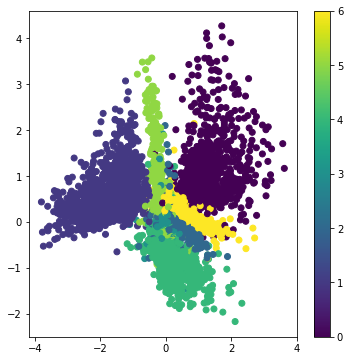

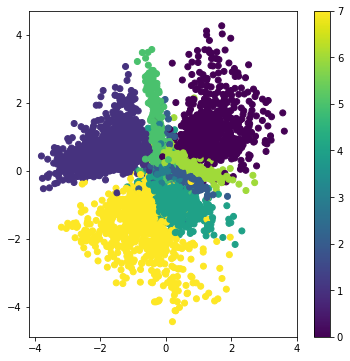

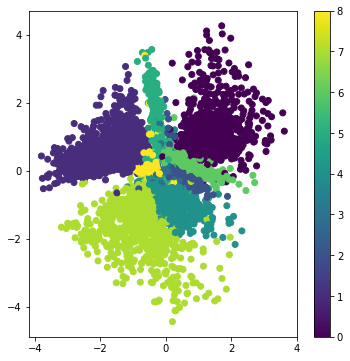

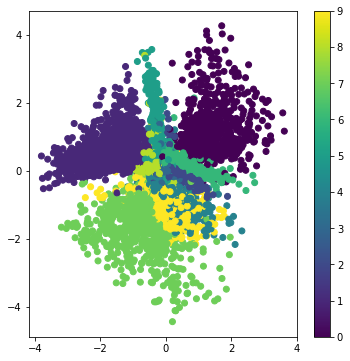

In [112]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for i in range(10):
    temp=y_test<=i
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[temp, 0], x_test_encoded[temp, 1], c=y_test[temp])
    plt.colorbar()
    plt.show()

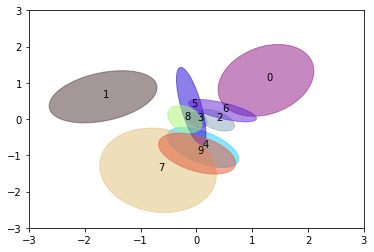

In [113]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for i in range(10):
    temp=y_test==i
    A1=cov.empirical_covariance(x_test_encoded[temp, :])
    M1=np.mean(x_test_encoded[temp, :],axis=0)
    #plt.figure(figsize=(6, 6))
    plot_cov_ellipse(A1/2, M1,alpha=0.5, color=np.random.random(3))
    plt.text(M1[0],M1[1],str(i))
    #plt.scatter(x_test_encoded[temp, 0], x_test_encoded[temp, 1], c=y_test[temp])
    #plt.colorbar()
plt.xlim([-3,3])
plt.ylim([-3,3])   
plt.show()

**Beter reconstruction loss on the validation set with 32 filters instead of 64**